In [23]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from tqdm import tqdm
import os

class ImdbDataset(Dataset):
    def __init__(self, is_train=True):
        # label genre
        with open('dataset/genres.txt', 'r') as f:
            genre_all = f.readlines()
            genre_all = [x.replace('\n','') for x in genre_all]
        self.genre2idx = {genre:idx for idx, genre in enumerate(genre_all)}

    def __getitem__(self, index):
        genre = self.data.iloc[index].genre

        # preprocess text
        title_vec = self.title_vector[index]
        title_tensor = torch.from_numpy(title_vec).float()

        # preprocess image
        img_vec = self.img_vector[index]
        img_tensor = torch.from_numpy(img_vec).float()        

        # preprocess label
        genre_vector = np.zeros(len(self.genre2idx))

        for g in genre:
            genre_vector[self.genre2idx[g]] = 1
        genre_tensor = torch.from_numpy(genre_vector).float()

        return title_tensor, img_tensor, genre_tensor

    def __len__(self):
        return len(self.data)

In [24]:
import torch
from torch.utils.data import DataLoader

# load dataset
train_data = torch.load('dataset/train_set_vgg19_hf.pt')
test_data = torch.load('dataset/test_set_vgg19_hf.pt')

# create dataloader
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)

(98, 25)

In [25]:
for title, img, genre in train_loader:
    print(title.shape, img.shape, genre.shape)
    break
for title, img, genre in test_loader:
    print(title.shape, img.shape, genre.shape)
    break

torch.Size([32, 10]) torch.Size([32, 1000]) torch.Size([32, 18])
torch.Size([32, 10]) torch.Size([32, 1000]) torch.Size([32, 18])


In [26]:
from torch import nn

class ImdbModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1010, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 18),
        )
        self.norm_img = nn.BatchNorm1d(1000)
        self.norm_title = nn.BatchNorm1d(10)


    def forward(self, title, img):
        # normalize
        title = self.norm_title(title)
        img = self.norm_img(img)

        x = torch.cat([title, img], dim=1)
        x = self.fc(x)
        return x
    
model = ImdbModel_2()
model

ImdbModel_2(
  (fc): Sequential(
    (0): Linear(in_features=1010, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=18, bias=True)
  )
  (norm_img): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm_title): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [28]:
from tqdm import tqdm
from torchmetrics.classification import MultilabelF1Score, MultilabelPrecision, MultilabelRecall

num_labels = genre.shape[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

history = {'train_loss': [], 'test_loss': []}
f1_score = {'train': [], 'test': []}

f1 = MultilabelF1Score(num_labels=num_labels, threshold=0.5, average='macro')
f1 = f1.to(device)
precision = MultilabelPrecision(num_labels=num_labels, threshold=0.5, average='macro')
precision = precision.to(device)
recall = MultilabelRecall(num_labels=num_labels, threshold=0.5, average='macro')
recall = recall.to(device)
 
def test(model):
    model.eval()
    test_loss = 0
    f1_all = 0
    precision_all = 0
    recall_all = 0

    with torch.no_grad():
        for title, img, genre in test_loader:
            title, img, genre = title.to(device), img.to(device), genre.to(device)
            outputs = model(title, img)
            loss = criterion(outputs, genre)
            test_loss += loss.item()
            
            f1_all += f1(outputs, genre)
            precision_all += precision(outputs, genre)
            recall_all += recall(outputs, genre)

    test_loss /= len(test_loader)
    f1_all /= len(test_loader)
    precision_all /= len(test_loader)
    recall_all /= len(test_loader)

    return test_loss, f1_all, precision_all, recall_all

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for idx, (title, img, genre) in enumerate(tqdm(train_loader)):
        title, img, genre = title.to(device), img.to(device), genre.to(device)
        optimizer.zero_grad()
        outputs = model(title, img)
        loss = criterion(outputs, genre)
        loss.backward()
        optimizer.step()

    train_loss = loss.item()
    test_loss, f1_all, precision_all, recall_all = test(model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, f1: {f1_all:.4f}, precision: {precision_all:.4f}, recall: {recall_all:.4f}')

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [00:02<00:00, 46.74it/s]


Epoch 1/20, train_loss: 1.6164, test_loss: 3.7032, f1: 0.1747, precision: 0.1262, recall: 0.4027


100%|██████████| 98/98 [00:02<00:00, 46.41it/s]


Epoch 2/20, train_loss: 2.0260, test_loss: 3.8411, f1: 0.1926, precision: 0.1454, recall: 0.3717


100%|██████████| 98/98 [00:02<00:00, 48.90it/s]


Epoch 3/20, train_loss: 3.3116, test_loss: 3.9610, f1: 0.2032, precision: 0.1487, recall: 0.4152


100%|██████████| 98/98 [00:02<00:00, 44.10it/s]


Epoch 4/20, train_loss: 5.6129, test_loss: 3.9834, f1: 0.2045, precision: 0.1573, recall: 0.3959


100%|██████████| 98/98 [00:02<00:00, 41.47it/s]


Epoch 5/20, train_loss: 5.0972, test_loss: 4.2421, f1: 0.2097, precision: 0.1560, recall: 0.4137


100%|██████████| 98/98 [00:02<00:00, 42.11it/s]


Epoch 6/20, train_loss: 4.9705, test_loss: 4.5150, f1: 0.1969, precision: 0.1537, recall: 0.3753


100%|██████████| 98/98 [00:02<00:00, 32.77it/s]


Epoch 7/20, train_loss: 2.8384, test_loss: 4.3243, f1: 0.2142, precision: 0.1640, recall: 0.4017


100%|██████████| 98/98 [00:02<00:00, 43.06it/s]


Epoch 8/20, train_loss: 4.2938, test_loss: 4.8964, f1: 0.2136, precision: 0.1646, recall: 0.3882


100%|██████████| 98/98 [00:02<00:00, 46.52it/s]


Epoch 9/20, train_loss: 1.7693, test_loss: 5.2719, f1: 0.2029, precision: 0.1496, recall: 0.3829


100%|██████████| 98/98 [00:02<00:00, 42.09it/s]


Epoch 10/20, train_loss: 1.5165, test_loss: 5.3493, f1: 0.2127, precision: 0.1632, recall: 0.3943


100%|██████████| 98/98 [00:02<00:00, 40.96it/s]


Epoch 11/20, train_loss: 4.5754, test_loss: 5.0394, f1: 0.2131, precision: 0.1614, recall: 0.3983


100%|██████████| 98/98 [00:02<00:00, 41.25it/s]


Epoch 12/20, train_loss: 2.0547, test_loss: 5.6769, f1: 0.2111, precision: 0.1610, recall: 0.4077


100%|██████████| 98/98 [00:02<00:00, 45.41it/s]


Epoch 13/20, train_loss: 3.8086, test_loss: 5.5196, f1: 0.2153, precision: 0.1624, recall: 0.4019


100%|██████████| 98/98 [00:02<00:00, 39.36it/s]


Epoch 14/20, train_loss: 0.9261, test_loss: 6.1946, f1: 0.2139, precision: 0.1649, recall: 0.3863


100%|██████████| 98/98 [00:02<00:00, 37.17it/s]


Epoch 15/20, train_loss: 1.1948, test_loss: 5.9846, f1: 0.2180, precision: 0.1671, recall: 0.3981


100%|██████████| 98/98 [00:02<00:00, 48.54it/s]


Epoch 16/20, train_loss: 4.4053, test_loss: 5.6968, f1: 0.2132, precision: 0.1684, recall: 0.3940


100%|██████████| 98/98 [00:02<00:00, 35.75it/s]


Epoch 17/20, train_loss: 5.9254, test_loss: 7.1282, f1: 0.2165, precision: 0.1686, recall: 0.3917


100%|██████████| 98/98 [00:02<00:00, 42.49it/s]


Epoch 18/20, train_loss: 4.0584, test_loss: 6.3647, f1: 0.2107, precision: 0.1587, recall: 0.3913


100%|██████████| 98/98 [00:02<00:00, 40.82it/s]


Epoch 19/20, train_loss: 1.7177, test_loss: 6.4729, f1: 0.2095, precision: 0.1550, recall: 0.3944


100%|██████████| 98/98 [00:02<00:00, 33.60it/s]


Epoch 20/20, train_loss: 0.8029, test_loss: 6.9646, f1: 0.2080, precision: 0.1510, recall: 0.4088


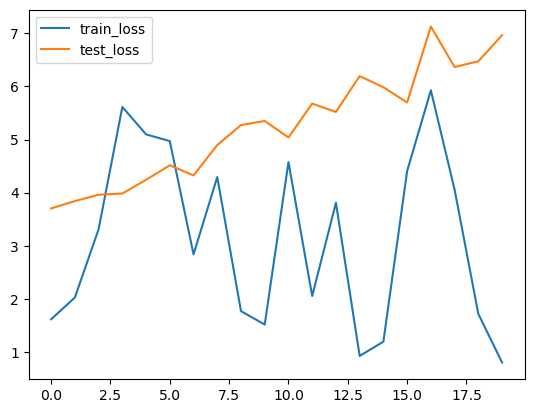

In [29]:
from matplotlib import pyplot as plt
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.legend()
plt.show()